In [1]:
import os
import torch
import matplotlib.pyplot as plt
from torch.functional import F
from typing import cast
from tqdm import tqdm
import random


%matplotlib inline
while not os.getcwd().endswith("nlp-playground"):
    os.chdir("..")
print(os.getcwd())
DATA_DIR = "data"
NAMES_FILE_PATH = os.path.join(DATA_DIR, "names.txt")

/Users/cristian/Personal/Projects/nlp-playground


Load the words

In [2]:
with open(NAMES_FILE_PATH, "r") as f:
    words = f.read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

Build the dictionary mapping of the characters to their corresponding integer values

In [4]:
chars = ["."] + sorted(list(set("".join(words))))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)
print(stoi)
print(itos)
print(vocab_size)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


Build the actual datased considering a sequence of block_size characters as input and the next character as the output

In [5]:
def build_dataset(words, block_size=None):
    if block_size is None:
        block_size = 3

    X, Y = [], []

    # iterate over words
    for word in words:
        # define a 3-character context window
        context = [0] * block_size
        # iterate over characters in the word
        for char in word + ".":
            # get the index of the character
            idx = stoi[char]
            X.append(context)
            Y.append(idx)
            # slide the context window one character to the right
            context = context[1:] + [idx]
    # convert the data to PyTorch tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


In [6]:
random.seed(42)
random.shuffle(words)
block_size = 3
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
X_tr, Y_tr = build_dataset(words[:n1], block_size)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size)
X_te, Y_te = build_dataset(words[n2:], block_size)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [31]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(42)
C = torch.randn(vocab_size, n_emb, generator=g)
W1 = (
    torch.randn(block_size * n_emb, n_hidden, generator=g)
    * 5
    / 3
    / ((block_size * n_emb) ** 0.5)
)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12297


In [32]:
max_steps = 200000
batch_size = 32
lossi = []

In [33]:
progress_bar = tqdm(range(max_steps), desc=f"Training")
for i in progress_bar:
    # build minibatch
    idx = torch.randint(0, X_tr.shape[0], (batch_size,))

    # Compute embeddings
    emb = C[X_tr[idx]]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = (
        bngain
        * (hpreact - hpreact.mean(0, keepdim=True))
        / hpreact.std(0, keepdim=True)
    ) + bnbias

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_tr[idx])
    # progress_bar.set_postfix(loss=loss.item())
    # print(f"loss: {loss.item()}")

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    if i % 1000 == 0:
        progress_bar.set_postfix(loss=f"{i:7d}/{max_steps:7d}: {loss.item()}")
    lossi.append(loss.log10().item())

Training: 100%|██████████| 200000/200000 [00:52<00:00, 3846.08it/s, loss=199000/ 200000: 2.1859729290008545]


In [34]:
@torch.no_grad()
def split_loss(split):
    x, y = {"train": {X_tr, Y_tr}, "val": {X_dev, Y_dev}, "test": {X_te, Y_te}}[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = (
        bngain
        * (hpreact - hpreact.mean(0, keepdim=True))
        / hpreact.std(0, keepdim=True)
    ) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.068983793258667
val 2.1111905574798584


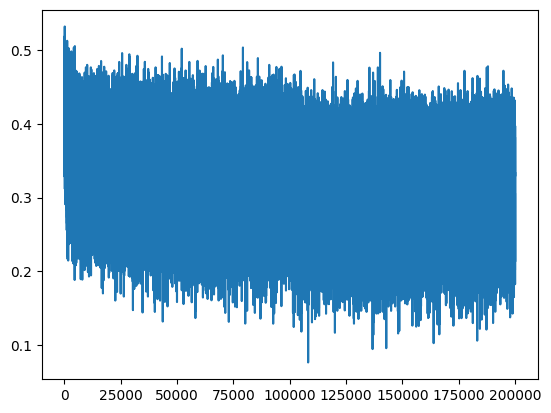

In [71]:
plt.plot(lossi)
plt.show()

In [14]:
emb = C[X_dev]
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.1540, grad_fn=<NllLossBackward0>)

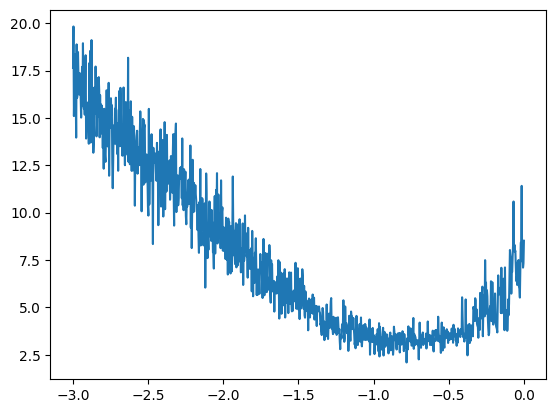

In [ ]:
plt.plot(lri, lossi)

In [52]:
C.shape

torch.Size([27, 2])

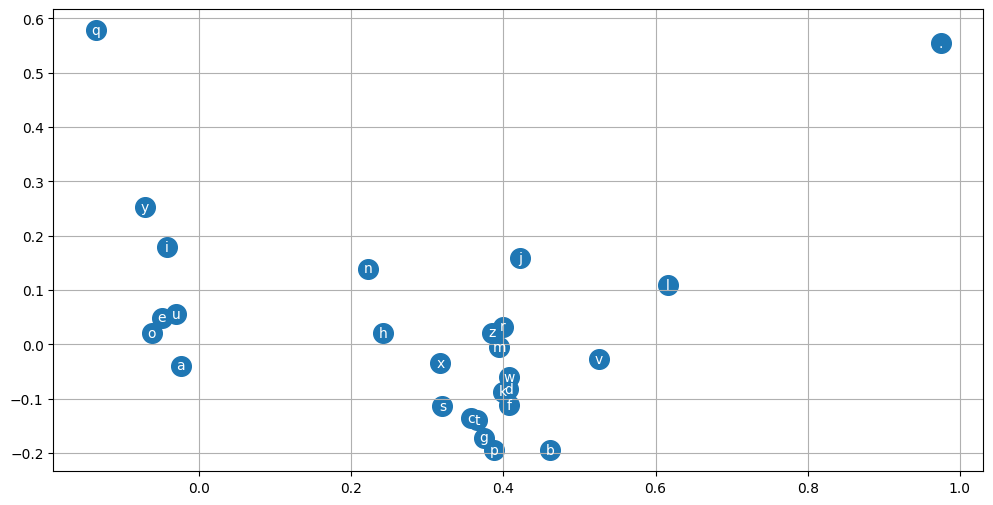

In [51]:
plt.figure(figsize=(12, 6))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white"
    )
plt.grid("minor")

In [97]:
g = torch.Generator().manual_seed(42)
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = logits.softmax(dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

anuelen.
tia.
marian.
davius.
amillaylen.
kemarce.
man.
epiacenden.
dazi.
kence.
jordon.
kalla.
mikhlynna.
cvahia.
aczalin.
tian.
tiyan.
marotte.
jena.
judgan.
